In [71]:
import pandas as pd
from apriori import Apriori
import statistics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [34]:
original_store_data = pd.read_csv("../Dataset/SampleSuperstore.csv")

In [35]:
print(original_store_data.shape)
original_store_data.head()

(9994, 13)


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [4]:
print(original_store_data['Ship Mode'].unique())
print(original_store_data['Segment'].unique())
print(original_store_data['Country'].unique())
print(original_store_data['Category'].unique())
print(original_store_data['Sub-Category'].unique())

['Second Class' 'Standard Class' 'First Class' 'Same Day']
['Consumer' 'Corporate' 'Home Office']
['United States']
['Furniture' 'Office Supplies' 'Technology']
['Bookcases' 'Chairs' 'Labels' 'Tables' 'Storage' 'Furnishings' 'Art'
 'Phones' 'Binders' 'Appliances' 'Paper' 'Accessories' 'Envelopes'
 'Fasteners' 'Supplies' 'Machines' 'Copiers']


In [5]:
algorithm = Apriori()
try:
    algorithm.valid_input_check(store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class


#### Changing to a suitable dataframe

In [6]:
store_data = original_store_data[['Postal Code', 'Sub-Category', 'Quantity']]
store_data = store_data.groupby(['Postal Code', 'Sub-Category']).sum()
# Convert quantities to 0/1
store_data['Quantity'] =  (store_data['Quantity']>0).astype(int)
# pivot table and convert it to sparse data
pivoted_store_data = store_data.pivot_table(index='Postal Code', columns='Sub-Category', values='Quantity', fill_value=0)
sparse_store_data = pivoted_store_data.astype(pd.SparseDtype(int, fill_value=0))

In [36]:
print(sparse_store_data.shape)
sparse_store_data.head()

(631, 17)


Sub-Category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
Postal Code,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1453,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
1752,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1841,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1


In [8]:
try:
    algorithm.valid_input_check(sparse_store_data)
except:
    print("The allowed values for a DataFrame are True, False, 0, 1. Found value Second Class")

## Apriori Algorithm and extract frequent items as features 

In [9]:
# check for the mean occurence for each combination 
item_count = algorithm.apriori(df=sparse_store_data, use_colnames=True, verbose=1, count=True, min_support=0.001)

Processing 17 combinations | Sampling itemset size 176531


In [10]:
print(f"Total number of combinations of all itemsets: {len(item_count)}")
average_occurence = round(sum(item_count['count'])/len(item_count), 2)
median_occurence = statistics.median(item_count['count'])
percentile_99 = np.percentile(item_count['count'], 99)
print(f"Average Occurence of each combination: {average_occurence}")
print(f"Median Occurence of each combination: {median_occurence}")
print(f"75 Percentile Occurence of each combination: {percentile_99}")

Total number of combinations of all itemsets: 131071
Average Occurence of each combination: 26.62
Median Occurence of each combination: 23.0
75 Percentile Occurence of each combination: 74.0


In [11]:
# We define frequent item as those that occur more than the average occurence
frequent_items = list(item_count[item_count['count']>percentile_99]['itemsets'])
len(frequent_items)

1256

In [12]:
new_col = frequent_items

### Data Preprocessing for Clustering Users

In [13]:
new_df = pd.DataFrame(index=sparse_store_data.index)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for i in sparse_store_data.index:
        for item in itemset:
            if sparse_store_data.loc[i][item] == 0:
                new_df.at[i, itemset] = 0
                break

100%|██████████| 1256/1256 [10:30<00:00,  1.99it/s]


In [51]:
# Adding Label to the new table with frequent items as features
final_df = new_df.merge(original_store_data[['Postal Code', 'Segment']], how='left', on='Postal Code').set_index('Postal Code')
"""
Combining label if multiple labels are found for the same Postal Code
eg: Postal 123 contains different transactions(rows) with different 'Segment' --> consumer and corporate, 
    it will be combined to one row with 'Segment' --> consumer, corporate
"""
final_df = final_df.groupby('Postal Code').agg({
    **{col: 'max' for col in final_df.columns if col not in ['Postal Code', 'Segment']},
    'Segment': lambda x: ', '.join(sorted(set(x)))
}).reset_index()
final_df.rename(columns={"Segment": "Label"}, inplace=True)

In [53]:
# Label Transform the Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Label'] = le.fit_transform(final_df['Label'])

In [88]:
# final_df.to_csv("../Result/SuperStoreFrequentFeatures1.csv")
print(final_df.shape)
final_df.head()

(631, 1257)


,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),(Labels),...,"(Storage, Paper, Chairs, Furnishings, Art, Phones, Binders)","(Tables, Storage, Paper, Furnishings, Art, Phones, Binders)","(Tables, Storage, Paper, Chairs, Furnishings, Phones, Binders)","(Paper, Chairs, Phones, Furnishings, Art, Accessories, Appliances, Binders)","(Storage, Paper, Phones, Furnishings, Art, Accessories, Appliances, Binders)","(Storage, Paper, Chairs, Phones, Furnishings, Accessories, Appliances, Binders)","(Storage, Paper, Chairs, Furnishings, Art, Accessories, Phones, Binders)","(Tables, Storage, Paper, Furnishings, Art, Accessories, Phones, Binders)","(Storage, Paper, Chairs, Phones, Furnishings, Art, Appliances, Binders)",Label
Postal Code,,,,,,,,,,,,,,,,,,,,,
1040,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1453,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1752,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1810,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841,0,1,1,1,0,1,0,1,1,1,...,1,1,1,0,0,0,0,0,1,2


### Data Preprocessing for Clustering Items

In [80]:
new_df = pd.DataFrame(index=sparse_store_data.columns)
new_df[new_col] = 1
for itemset in tqdm(new_col):
    for item in sparse_store_data.columns:
        if item not in itemset:
            new_df.at[item, itemset] = 0


100%|██████████| 1256/1256 [00:00<00:00, 5749.86it/s]


In [85]:
final_df2 = new_df.merge(original_store_data[['Sub-Category', 'Category']], how='left', on='Sub-Category').set_index('Sub-Category').drop_duplicates(keep='first')
final_df2.rename(columns={"Category": "Label"}, inplace=True)

le = LabelEncoder()
final_df2['Label'] = le.fit_transform(final_df2['Label'])

In [89]:
# final_df2.to_csv("../Result/SuperStoreFrequentFeatures2.csv")
print(final_df2.shape)
final_df2.head()

(17, 1257)


,(Accessories),(Appliances),(Art),(Binders),(Bookcases),(Chairs),(Envelopes),(Fasteners),(Furnishings),(Labels),...,"(Storage, Paper, Chairs, Furnishings, Art, Phones, Binders)","(Tables, Storage, Paper, Furnishings, Art, Phones, Binders)","(Tables, Storage, Paper, Chairs, Furnishings, Phones, Binders)","(Paper, Chairs, Phones, Furnishings, Art, Accessories, Appliances, Binders)","(Storage, Paper, Phones, Furnishings, Art, Accessories, Appliances, Binders)","(Storage, Paper, Chairs, Phones, Furnishings, Accessories, Appliances, Binders)","(Storage, Paper, Chairs, Furnishings, Art, Accessories, Phones, Binders)","(Tables, Storage, Paper, Furnishings, Art, Accessories, Phones, Binders)","(Storage, Paper, Chairs, Phones, Furnishings, Art, Appliances, Binders)",Label
Sub-Category,,,,,,,,,,,,,,,,,,,,,
Accessories,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,2
Appliances,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,1,1
Art,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,0,1,1,1,1
Binders,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Bookcases,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering Different Users (based on postal code)

### K Means Clustering (K=7)

In [103]:
print("Number of unique labels: ", len(final_df['Label'].unique()))

Number of unique labels:  7


In [104]:
from sklearn.cluster import KMeans

X = final_df.iloc[:, :-1]
kmeans = KMeans(n_clusters=len(final_df['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [105]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score

print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")


Silhouette Score: 0.5037051122002923
Calinski Harabasz Score: 226.16801153703938
Davies Bouldin Score: 1.7925466409131396
Adjusted Rand Index: -0.03771071865334091


#### t-SNE

In [106]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, init='pca', perplexity=25).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(631, 2)

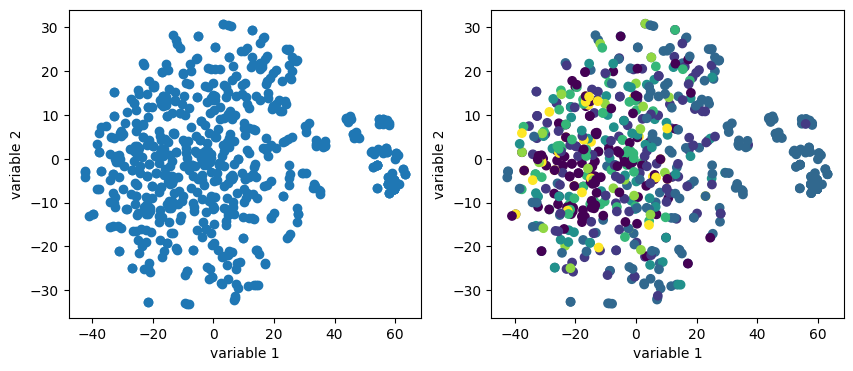

In [107]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [108]:
kmeans = KMeans(n_clusters=len(final_df['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [109]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df['Label'] , kmeans_results)}")


Silhouette Score: -0.036349671816071995
Calinski Harabasz Score: 145.18465331283468
Davies Bouldin Score: 4.086854850660862
Adjusted Rand Index: 0.07773463814443561


## Clustering Different Items (based on sub-category)

### K Means Clustering (K=3)

In [155]:
print("Number of unique labels: ", len(final_df2['Label'].unique()))

Number of unique labels:  3


In [156]:
X = final_df2.iloc[:, :-1]
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X)
kmeans_results = kmeans.labels_

In [157]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: 0.1264376331046648
Calinski Harabasz Score: 1.694547273007476
Davies Bouldin Score: 1.823416531490898
Adjusted Rand Index: -0.09863945578231292


#### t-SNE

In [158]:
X_embedded = TSNE(n_components=2, init='pca', perplexity=4).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded)
X_embedded.shape

(17, 2)

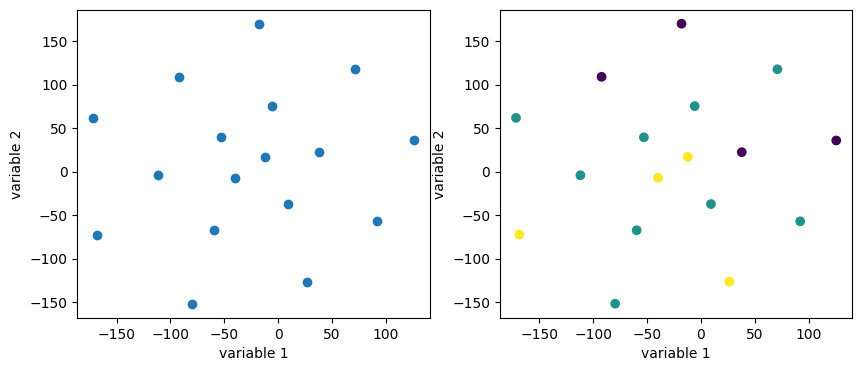

In [159]:
# t-SNE does not result in clear clusters too

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], cmap='viridis')
axes[0].set_xlabel("variable 1")
axes[0].set_ylabel("variable 2")
axes[1].scatter(x=X_embedded.iloc[:, 0], y=X_embedded.iloc[:, 1], c=final_df2['Label'], cmap='viridis')
axes[1].set_xlabel("variable 1")
axes[1].set_ylabel("variable 2")
plt.show()

In [160]:
kmeans = KMeans(n_clusters=len(final_df2['Label'].unique()), random_state=0, init='k-means++').fit(X_embedded)
kmeans_results = kmeans.labels_

In [161]:
print(f"Silhouette Score: {silhouette_score(X, kmeans_results, metric='euclidean')}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(X, kmeans_results)}")
print(f"Davies Bouldin Score: {davies_bouldin_score(X, kmeans_results)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(final_df2['Label'] , kmeans_results)}")

Silhouette Score: -0.04661026612912735
Calinski Harabasz Score: 0.9866271289467418
Davies Bouldin Score: 3.2367727199266034
Adjusted Rand Index: -0.003937007874015748
